# Benchmarking visualization analogue search test set
The results of running MS2Query, MS2Deepscore and (modified) cosine on the test spectra of all spectra from 250 inchikeys, that do not have an exact library hit is visualized below.
In the file generate_predictions_for_test_data the predictions are generated and stored in the format:
List[Tuple(best_spectrum_id, predicted_score)]

In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from ms2query.utils import load_pickled_file

# General file locations
data_folder = "C:/Users/jonge094/PycharmProjects/PhD_MS2Query/ms2query/data"
benchmarking_results_folder = os.path.join(data_folder, "libraries_and_models/gnps_15_12_2021/benchmarking")
library_folder = os.path.join(data_folder, "libraries_and_models/gnps_15_12_2021/")

In [2]:
# Load in general files:
tanimoto_scores_file_name = os.path.join(library_folder, "in_between_files/GNPS_15_12_2021_pos_tanimoto_scores.pickle")
sqlite_file_location = os.path.join(library_folder, "library_gnps_15_12/library_GNPS_15_12_2021.sqlite")
test_spectra_3000 = load_pickled_file(os.path.join(library_folder,
                                                   "in_between_files/GNPS_15_12_2021_pos_test_3000_spectra.pickle"))
test_spectra_250 = load_pickled_file(os.path.join(library_folder,
                                                   "in_between_files/GNPS_15_12_2021_pos_test_250_inchikeys.pickle"))

# Load in predictions:
df_results_ms2query = pd.read_csv(os.path.join(benchmarking_results_folder, "GNPS_15_12_2021_pos_test_250_inchikeys.csv"))
results_mod_cosine = load_pickled_file(os.path.join(benchmarking_results_folder, "highest_mod_cosine_mass_tol_100_test_spectra_250.pickle"))
results_ms2deepscore = load_pickled_file(os.path.join(benchmarking_results_folder, "ms2deepscores_within_100_Da_test_spectra_250.pickle"))

# convert to list with tuple format and add spectrum objects
results_ms2query_250 = [(x[0], x[1], test_spectra_250[x[2]-1]) for x in df_results_ms2query[["spectrum_ids", "ms2query_model_prediction", "query_spectrum_nr"]].to_numpy()]
results_mod_cosine_250 = [(results_mod_cosine[i][0], results_mod_cosine[i][1], test_spectra_250[i]) for i in range(len(test_spectra_250))]
results_ms2deepscore_250 = [(results_ms2deepscore[i][0], results_ms2deepscore[i][1], test_spectra_250[i]) for i in range(len(test_spectra_250))]

## Add tanimoto score
The tanimoto score is added to each tuple as ground thruth. 

In [3]:
from ms2query.query_from_sqlite_database import get_metadata_from_sqlite
from tqdm.notebook import tqdm
 

def select_best_match_and_calculate_tanimoto_score(tanimoto_scores_file, best_matches, sqlite_file_location):
    """Returns a list with a tuple(best_match_spectrum_id, best_match_score, tanimoto_score)
    
    best_matches:
        List with tuples, first value is the highest scoring spectum_id and second value is the score (e.g. ms2ds, cos, or ms2query), third value are the test spectra
    """
    best_match_and_tanimoto = []
    tanimoto_scores = load_pickled_file(tanimoto_scores_file)
    for best_match_spectrum_id, predicted_score, test_spectrum in tqdm(best_matches):
        test_spectrum_inchikey = test_spectrum.get("inchikey")[:14]
        best_match_inchikey = get_metadata_from_sqlite(sqlite_file_location, [best_match_spectrum_id], "spectrumid")[best_match_spectrum_id]["inchikey"][:14]
        tanimoto_score = tanimoto_scores.loc[best_match_inchikey, test_spectrum_inchikey]
        
        best_match_and_tanimoto.append((best_match_spectrum_id, predicted_score, tanimoto_score, test_spectrum))
    return best_match_and_tanimoto

In [4]:
results_ms2query_250 = select_best_match_and_calculate_tanimoto_score(tanimoto_scores_file_name, results_ms2query_250, sqlite_file_location)
results_mod_cosine_250 = select_best_match_and_calculate_tanimoto_score(tanimoto_scores_file_name, results_mod_cosine_250, sqlite_file_location)
results_ms2deepscore_250 = select_best_match_and_calculate_tanimoto_score(tanimoto_scores_file_name, results_ms2deepscore_250, sqlite_file_location)

  0%|          | 0/2984 [00:00<?, ?it/s]

  0%|          | 0/2987 [00:00<?, ?it/s]

  0%|          | 0/2987 [00:00<?, ?it/s]

# Visualize results

In [144]:
def select_threshold_for_recall(predictions, recall, nr_of_spectra):
    threshold = 0
    step = 0.0001
    stop = False
    while not stop:
        found_recall = len([scores[2] for scores in predictions if scores[1] > threshold])/nr_of_spectra
        if found_recall > recall:
            threshold += step
        else:
            stop = True
    return threshold, found_recall

def compare_tanimoto_score_distribution(ms2query_scores, ms2ds_scores, mod_cos_scores, recall, nr_of_spectra):
    threshold_ms2q, found_recall_ms2q = select_threshold_for_recall(ms2query_scores, recall, nr_of_spectra)
    threshold_ms2ds, found_recall_ms2ds = select_threshold_for_recall(ms2ds_scores, recall, nr_of_spectra)
    threshold_mod_cos, found_recall_mod_cos = select_threshold_for_recall(mod_cos_scores, recall, nr_of_spectra)
    print(f"MS2Query Threshold:{threshold_ms2q:.4f} Recall:{found_recall_ms2q:.3f}")
    print(f"MS2Deepscore Threshold:{threshold_ms2ds:.4f} Recall:{found_recall_ms2ds:.3f}")
    print(f"Modified cosine Threshold:{threshold_mod_cos:.4f} Recall:{found_recall_mod_cos:.3f}")
    
    weight_to_convert_to_percentage = 100/nr_of_spectra
    bins = np.linspace(0, 1, 11)

    selected_scores_ms2q = [scores[2] for scores in ms2query_scores if scores[1] > threshold_ms2q]
    weights_ms2q = [weight_to_convert_to_percentage] * len(selected_scores_ms2q)
    
    selected_scores_ms2ds = [scores[2] for scores in ms2ds_scores if scores[1] > threshold_ms2ds]
    weights_ms2ds = [weight_to_convert_to_percentage] * len(selected_scores_ms2ds)
    
    selected_scores_mod_cos = [scores[2] for scores in mod_cos_scores if scores[1] > threshold_mod_cos]
    weights_mod_cos = [weight_to_convert_to_percentage] * len(selected_scores_mod_cos)

    plt.hist([selected_scores_ms2q, selected_scores_ms2ds, selected_scores_mod_cos], bins, 
             label = ["MS2Query", "MS2Deepscore", "Mod_cos"], weights = [weights_ms2q, weights_ms2ds, weights_mod_cos])
    
    plt.legend(loc = "upper center", title = "Select on:")
    plt.xlabel("tanimoto_score")
    plt.ylabel("Percentage of matches (%)")
#     plt.ylim(0, 11)

    plt.show


MS2Query Threshold:0.0000 Recall:0.999
MS2Deepscore Threshold:0.0000 Recall:1.000
Modified cosine Threshold:0.0000 Recall:1.000


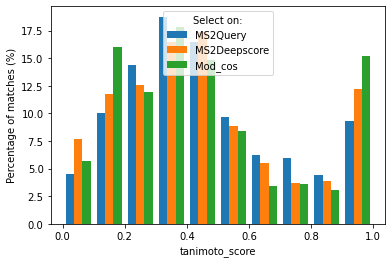

In [145]:
compare_tanimoto_score_distribution(results_ms2query_250, results_ms2deepscore_250, results_mod_cosine_250, 1, len(test_spectra_250)) # 50%

MS2Query Threshold:0.6330 Recall:0.349
MS2Deepscore Threshold:0.9664 Recall:0.348
Modified cosine Threshold:0.9883 Recall:0.350


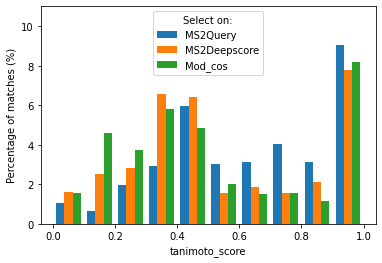

In [118]:
compare_tanimoto_score_distribution(results_ms2query_250, results_ms2deepscore_250, results_mod_cosine_250, 0.35, len(test_spectra_250)) # 50%

MS2Query Threshold:0.5838 Recall:0.599
MS2Deepscore Threshold:0.9305 Recall:0.600
Modified cosine Threshold:0.9396 Recall:0.600


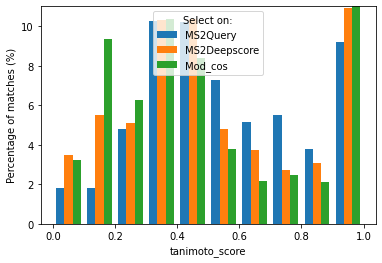

In [119]:
compare_tanimoto_score_distribution(results_ms2query_250, results_ms2deepscore_250, results_mod_cosine_250, 0.6, len(test_spectra_250))

MS2Query Threshold:0.7881 Recall:0.200
MS2Deepscore Threshold:0.9835 Recall:0.200
Modified cosine Threshold:0.9979 Recall:0.198


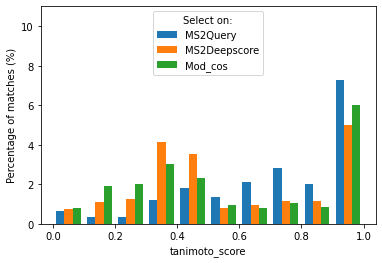

In [120]:
compare_tanimoto_score_distribution(results_ms2query_250, results_ms2deepscore_250, results_mod_cosine_250, 0.2, len(test_spectra_250))

In [103]:
def avg_tanimoto_vs_percentage_found(selection_criteria_and_tanimoto, cut_off_maximum, steps, legend_label):
    cut_offs = {}
    percentages_found = []
    average_tanimoto_score = []
    for i in range(steps):
        cut_off = cut_off_maximum/steps * i
        selected_scores = [scores[2] for scores in selection_criteria_and_tanimoto if scores[1] > cut_off]
        percentages_found.append(len(selected_scores)/len(selection_criteria_and_tanimoto)*100)
        average_tanimoto_score.append(sum(selected_scores)/len(selected_scores))
    plt.plot(percentages_found, average_tanimoto_score, label = legend_label)
    plt.xlim(100,10)
    plt.ylim(0, 1)
    plt.xlabel("Recall (%)")
    plt.ylabel("Average tanimoto score")
    plt.legend(loc = "lower right", title = "Select on highest:")
    plt.show

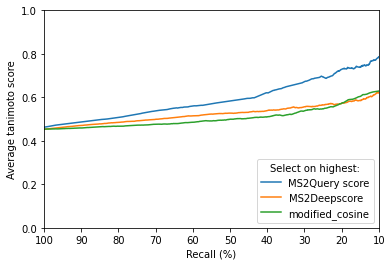

In [104]:
avg_tanimoto_vs_percentage_found(results_ms2query_250, 0.945, 10000, "MS2Query score")
avg_tanimoto_vs_percentage_found(results_ms2deepscore_250, 1, 10000, "MS2Deepscore")
avg_tanimoto_vs_percentage_found(results_mod_cosine_250, 1, 10000, "modified_cosine")

# Performance based on mass range

Threshold:0.9832 Recall:0.399


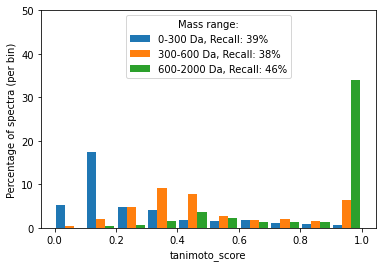

In [136]:
from matplotlib import pyplot as plt
import numpy as np

def plot_tanimoto_score_distr_masses(scores_and_tanimoto, recall, mass_bins, nr_of_spectra):
    cut_off_ms2q, found_recall_ms2q = select_threshold_for_recall(scores_and_tanimoto, recall, nr_of_spectra)
    print(f"Threshold:{cut_off_ms2q:.4f} Recall:{found_recall_ms2q:.3f}")

    bins = np.linspace(0, 1, 11)
    ms2q_scores_list = []
    label_list = []
    weight_list = []
    for i in range(len(mass_bins)-1):
        min_mass = mass_bins[i]
        max_mass = mass_bins[i+1]
        
        ms2query_and_tanimoto_mass_range = [scores for scores in scores_and_tanimoto if scores[3].get("parent_mass") > min_mass and scores[3].get("parent_mass") < max_mass]

        # Select scores for ms2query
        selected_scores_ms2q = [scores[2] for scores in ms2query_and_tanimoto_mass_range if scores[1] > cut_off_ms2q]
        ms2q_percentage_selected = len(selected_scores_ms2q)/len(ms2query_and_tanimoto_mass_range)*100
#         print("mass range ",min_mass, "-", max_mass)
#         print(len(ms2query_and_tanimoto_mass_range))
#         print(ms2q_percentage_selected)
        weight_to_convert_to_percentage = 100/len(ms2query_and_tanimoto_mass_range)
        weights_ms2q = [weight_to_convert_to_percentage] * len(selected_scores_ms2q)
        ms2q_scores_list.append(selected_scores_ms2q)
        label_list.append(str(min_mass) + "-" + str(max_mass) + " Da, Recall: " + str(int(ms2q_percentage_selected)) + "%")
        weight_list.append(weights_ms2q)
#     print(ms2q_scores_list)
#     print(label_list)
    
    
    plt.hist(ms2q_scores_list, bins, label = label_list, weights = weight_list, stacked=False, rwidth = 0.9)

    plt.legend(loc = "upper center", title = "Mass range:")

    plt.xlabel("tanimoto_score")
    plt.ylabel("Percentage of spectra (per bin)")
    plt.ylim(0, 50)

    plt.show
plot_tanimoto_score_distr_masses(results_mod_cosine_250, 0.4, [0,300, 600, 2000], len(test_spectra_250))

Threshold:0.9601 Recall:0.399


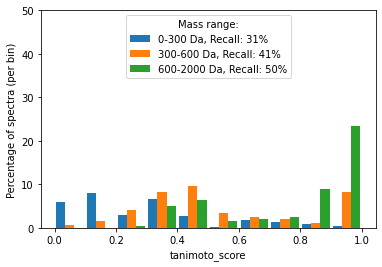

In [138]:
plot_tanimoto_score_distr_masses(results_ms2deepscore_250, 0.4, [0,300, 600, 2000], len(test_spectra_250))

Threshold:0.6677 Recall:0.300


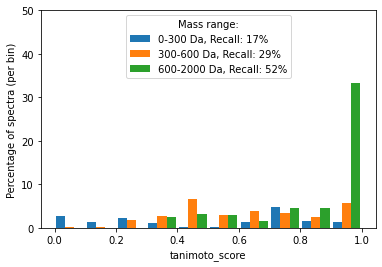

In [142]:
plot_tanimoto_score_distr_masses(results_ms2query_250, 0.3, [0,300, 600, 2000], len(test_spectra_250))

# Best Tanimoto score

0.9178629677841729


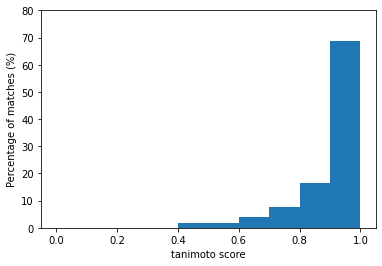

In [94]:
def plot_best_tanimoto_score_distribution(spectra, tanimoto_scores):
    inchikeys = [spectrum.get("inchikey")[:14] for spectrum in spectra]
    unique_inchikeys = list(set(inchikeys))
    
    # remove unique inchikeys from rows
    tanimoto_scores_removed = tanimoto_scores[~tanimoto_scores.index.isin(unique_inchikeys)]
    highest_tanimoto_list = []
    for inchikey in inchikeys:
        highest_tanimoto_score = tanimoto_scores_removed[inchikey].max()
        highest_tanimoto_list.append(highest_tanimoto_score)
    
    weight_to_convert_to_percentage = 100/len(spectra)
    weights = [weight_to_convert_to_percentage] * len(highest_tanimoto_list)
    
    average_tanimoto = sum(highest_tanimoto_list)/len(inchikeys)
    print(average_tanimoto)
    plt.xlabel("tanimoto score")
    plt.ylabel("Percentage of matches (%)")
    plt.ylim(0,80)
    
    plt.hist(highest_tanimoto_list, weights = weights, bins = np.linspace(0, 1, 11))
    plt.show()
plot_best_tanimoto_score_distribution(test_spectra_250, load_pickled_file(tanimoto_scores_file_name))

  0%|          | 0/250 [00:00<?, ?it/s]

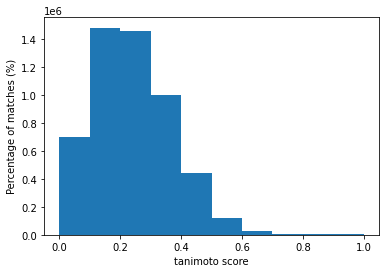

In [146]:
def plot_average_tanimoto_distribution(spectra, tanimoto_scores):
    bins = np.linspace(0, 1, 11)

    inchikeys = [spectrum.get("inchikey")[:14] for spectrum in spectra]
    unique_inchikeys = list(set(inchikeys))
    
    all_inchikeys = []
    for row in tqdm(unique_inchikeys):
        all_inchikeys += list(tanimoto_scores[row])
        
    weight_to_convert_to_percentage = 100/len(all_inchikeys)
    
    matches = []
    
#     weights = [weight_to_convert_to_percentage] * len(all_inchikeys)
    plt.xlabel("tanimoto score")
    plt.ylabel("Percentage of matches (%)")
    plt.hist(all_inchikeys, bins = bins)
#     plt.ylim(0,80)

    plt.show()
plot_average_tanimoto_distribution(test_spectra_250, load_pickled_file(tanimoto_scores_file_name))

# Additional functions for plotting

In [ ]:
def plot_tanimoto_score_distribution_for_cutoff(scores_and_tanimoto, cut_offs, legend_title, nr_of_spectra):
    """Plots the tanimoto score distribution for all hits above a threshold.
    
    scores_and_tanimoto:
    list with tuples containing (best_match_spectrum_id, predicted_score, tanimoto_score, test_spectrum)
    """
    bins = np.linspace(0, 1, 11)

    weight_to_convert_to_percentage = 100/nr_of_spectra

    for cut_off in cut_offs:
        selected_scores = [scores[2] for scores in scores_and_tanimoto if scores[1] > cut_off]
        print("percentage selected = " + str(len(selected_scores)/nr_of_spectra*100))
        weights = [weight_to_convert_to_percentage] * len(selected_scores)
        
        plt.hist(selected_scores, bins, label = f"{cut_off:.2f}", weights = weights, histtype = "step")
    
    plt.legend(loc = "upper center", title = legend_title, ncol = 3)
    plt.xlabel("tanimoto_score")
    plt.ylabel("Percentage of matches (%)")
    plt.ylim(0, 25)

    plt.show